In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

    np.random.seed(0)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import logging

logging.basicConfig(level=logging.WARN)


<IPython.core.display.Javascript object>

In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv1D,
    SpatialDropout1D,
    LocallyConnected1D,
    Dense,
    Reshape,
    MaxPooling1D,
    BatchNormalization,
    Activation,
    LayerNormalization,
)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.layers import WeightNormalization

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


from itertools import repeat
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


<IPython.core.display.Javascript object>

In [4]:
import tensorflow_addons as tfa

tfa.options.TF_ADDONS_PY_OPS = True

<IPython.core.display.Javascript object>

In [5]:
def word_to_np_array(word, cut_length):
    result = np.zeros(cut_length, dtype="uint8")
    for i, letter in enumerate(word[:cut_length]):
        result[i] = ord(letter)
    return result

<IPython.core.display.Javascript object>

In [6]:
def line_to_img(line, cut_length):
    result = np.zeros((line.shape[0], cut_length), dtype="uint8")
    for i in range(line.shape[0]):
        result[i] = word_to_np_array(line[i], cut_length)
    return result

<IPython.core.display.Javascript object>

In [7]:
def do_parallel_numpy(map_func, iter_params, constant_params=None):
    repeated_params = (
        [] if constant_params is None else list(map(repeat, constant_params))
    )
    results = None
    with PoolExecutor() as executor:
        results = np.stack(
            list(executor.map(map_func, *iter_params, *repeated_params)), axis=0
        )
    return results

<IPython.core.display.Javascript object>

In [8]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

dataset_name = "census-income"
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")
out_test = Path(os.getcwd() + "/data/" + dataset_name + "_test.csv")

download(url, out, force=False)
download(url_test, out_test, force=False)


File already exists.
File already exists.


<IPython.core.display.Javascript object>

In [11]:
cols = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "target",
]

<IPython.core.display.Javascript object>

In [12]:
train = pd.read_csv(out, names=cols)
test = pd.read_csv(out_test, names=cols, skiprows=2)
target = "target"

train[target] = train[target].str.strip()
# Test has . in label, let's clean it
test[target] = test[target].str.strip().str.strip(".")

<IPython.core.display.Javascript object>

In [13]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [14]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
test[target] = target_encoder.transform(test[target].values.reshape(-1))

<IPython.core.display.Javascript object>

In [15]:
used_columns = list(set(train.columns.tolist()) - set([target]) - set(["Set"]))
used_columns

['hours-per-week',
 'education-num',
 'education',
 'sex',
 'relationship',
 'age',
 'capital-gain',
 'occupation',
 'workclass',
 'marital-status',
 'race',
 'native-country',
 'fnlwgt',
 'capital-loss']

<IPython.core.display.Javascript object>

In [16]:
train["Set"] = np.random.choice(
    ["train", "valid"], p=[0.8, 0.2], size=(train.shape[0],)
)

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index

X_train = np.char.strip(train[used_columns].values[train_indices].astype("str"))
X_valid = np.char.strip(train[used_columns].values[valid_indices].astype("str"))

y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]

# Test here should be ignored for training, only purpose is benching with paper values
X_test = np.char.strip(test[used_columns].values.astype("str"))
y_test = test[target].values

del train, test, train_indices, valid_indices

<IPython.core.display.Javascript object>

In [17]:
X_train.shape

(26072, 14)

<IPython.core.display.Javascript object>

In [18]:
INPUT_DIM = X_train.shape[1]
NB_CHANNELS = np.vectorize(len)(X_train).max()
NB_CHANNELS

26

<IPython.core.display.Javascript object>

In [19]:
line_to_img(X_train[0], 27).shape

(14, 27)

<IPython.core.display.Javascript object>

In [20]:
X_train_preproc = do_parallel_numpy(line_to_img, [X_train], [NB_CHANNELS])
X_valid_preproc = do_parallel_numpy(line_to_img, [X_valid], [NB_CHANNELS])
X_test_preproc = do_parallel_numpy(line_to_img, [X_test], [NB_CHANNELS])

<IPython.core.display.Javascript object>

Y_train_preproc = to_categorical(y_train)
Y_valid_preproc = to_categorical(y_valid)
Y_test_preproc = to_categorical(y_test)

In [21]:
def build_model(input_dim, nb_channels, conv_dim=[], lconv_dim=[]):
    activation = mish
    optimizer = Lookahead(RectifiedAdam(1e-3), sync_period=6, slow_step_size=0.5)

    input_layer = Input(shape=(input_dim, nb_channels), name="input")
    x_layer = input_layer
    for i, conv_layer in enumerate(conv_dim):
        name = f"block_conv_{i}_"
        x_layer = Conv1D(
            filters=conv_layer,
            padding="valid",
            kernel_size=1,
            strides=1,
            name=name + "conv",
            use_bias=False,
            activation=None,
        )(x_layer)
        x_layer = BatchNormalization(name=name + "nb")(x_layer)
        x_layer = Activation(activation, name=name + "activation")(x_layer)

    for i, lconv_layer in enumerate(lconv_dim):
        name = f"block_lconv_{i}_"
        x_layer = LocallyConnected1D(
            filters=lconv_layer,
            padding="valid",
            kernel_size=1,
            strides=1,
            name=name + "lconv",
            use_bias=False,
            activation=None,
        )(x_layer)
        x_layer = BatchNormalization(name=name + "nb")(x_layer)
        x_layer = Activation(activation, name=name + "activation")(x_layer)

    nb_filters = lconv_dim[-1] if len(lconv_dim) > 0 else conv_dim[-1]
    x_layer = Reshape((input_dim * nb_filters,), name="reshape")(x_layer)
    x_layer = Dense(1, activation="sigmoid", name="output")(x_layer)

    model = Model(inputs=[input_layer], outputs=[x_layer], name="first_model")
    model.compile(loss="binary_crossentropy", optimizer=optimizer)

    return model

<IPython.core.display.Javascript object>

In [22]:
model = build_model(INPUT_DIM, NB_CHANNELS, conv_dim=[64], lconv_dim=[128, 64, 32])

<IPython.core.display.Javascript object>

In [23]:
model.summary()

Model: "first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14, 26)]          0         
_________________________________________________________________
block_conv_0_conv (Conv1D)   (None, 14, 64)            1664      
_________________________________________________________________
block_conv_0_nb (BatchNormal (None, 14, 64)            256       
_________________________________________________________________
block_conv_0_activation (Act (None, 14, 64)            0         
_________________________________________________________________
block_lconv_0_lconv (Locally (None, 14, 128)           114688    
_________________________________________________________________
block_lconv_0_nb (BatchNorma (None, 14, 128)           512       
_________________________________________________________________
block_lconv_0_activation (Ac (None, 14, 128)           

<IPython.core.display.Javascript object>

In [24]:
y_train.shape

(26072,)

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    X_train_preproc,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(X_valid_preproc, y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=100, verbose=1)],
)

Epoch 1/2000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


26/26 [==============================] - 6s 232ms/step - loss: 0.5426 - val_loss: 0.6850
Epoch 2/2000
26/26 [==============================] - 5s 205ms/step - loss: 0.3813 - val_loss: 0.6861
Epoch 3/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.3558 - val_loss: 0.6881
Epoch 4/2000
26/26 [==============================] - 5s 203ms/step - loss: 0.3451 - val_loss: 0.6893
Epoch 5/2000
26/26 [==============================] - 5s 195ms/step - loss: 0.3415 - val_loss: 0.6888
Epoch 6/2000
26/26 [==============================] - 5s 201ms/step - loss: 0.3392 - val_loss: 0.6885
Epoch 7/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.3365 - val_loss: 0.6860
Epoch 8/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.3345 - val_loss: 0.6771
Epoch 9/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.3345 - val_loss: 0.6625
Epoch 10/2000
26/26 [==============================] - 5s 206ms/step - loss: 0.3316 - val_loss:

Epoch 81/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.2957 - val_loss: 0.3039
Epoch 82/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2917 - val_loss: 0.3080
Epoch 83/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2922 - val_loss: 0.3004
Epoch 84/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2932 - val_loss: 0.2935
Epoch 85/2000
26/26 [==============================] - 5s 195ms/step - loss: 0.2927 - val_loss: 0.2907
Epoch 86/2000
26/26 [==============================] - 5s 204ms/step - loss: 0.2933 - val_loss: 0.3066
Epoch 87/2000
26/26 [==============================] - 5s 199ms/step - loss: 0.2934 - val_loss: 0.2993
Epoch 88/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2915 - val_loss: 0.3177
Epoch 89/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2903 - val_loss: 0.2987
Epoch 90/2000
26/26 [==============================] - 5s 205ms/step - lo

Epoch 160/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2825 - val_loss: 0.2871
Epoch 161/2000
26/26 [==============================] - 5s 194ms/step - loss: 0.2830 - val_loss: 0.2940
Epoch 162/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.2832 - val_loss: 0.2848
Epoch 163/2000
26/26 [==============================] - 5s 204ms/step - loss: 0.2857 - val_loss: 0.2986
Epoch 164/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2835 - val_loss: 0.3006
Epoch 165/2000
26/26 [==============================] - 5s 204ms/step - loss: 0.2836 - val_loss: 0.2918
Epoch 166/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2843 - val_loss: 0.2895
Epoch 167/2000
26/26 [==============================] - 5s 199ms/step - loss: 0.2821 - val_loss: 0.2916
Epoch 168/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2828 - val_loss: 0.2853
Epoch 169/2000
26/26 [==============================] - 5s 208ms

Epoch 239/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2755 - val_loss: 0.2843
Epoch 240/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2764 - val_loss: 0.2815
Epoch 241/2000
26/26 [==============================] - 5s 194ms/step - loss: 0.2759 - val_loss: 0.2795
Epoch 242/2000
26/26 [==============================] - 5s 206ms/step - loss: 0.2764 - val_loss: 0.2797
Epoch 243/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2764 - val_loss: 0.2807
Epoch 244/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.2751 - val_loss: 0.2815
Epoch 245/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2768 - val_loss: 0.2959
Epoch 246/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.2757 - val_loss: 0.2783
Epoch 247/2000
26/26 [==============================] - 5s 203ms/step - loss: 0.2752 - val_loss: 0.2795
Epoch 248/2000
26/26 [==============================] - 5s 195ms

Epoch 318/2000
26/26 [==============================] - 5s 193ms/step - loss: 0.2689 - val_loss: 0.2792
Epoch 319/2000
26/26 [==============================] - 5s 195ms/step - loss: 0.2713 - val_loss: 0.2869
Epoch 320/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2700 - val_loss: 0.2842
Epoch 321/2000
26/26 [==============================] - 5s 195ms/step - loss: 0.2719 - val_loss: 0.2781
Epoch 322/2000
26/26 [==============================] - 5s 207ms/step - loss: 0.2696 - val_loss: 0.2786
Epoch 323/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2691 - val_loss: 0.2810
Epoch 324/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2684 - val_loss: 0.2777
Epoch 325/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2692 - val_loss: 0.2805
Epoch 326/2000
26/26 [==============================] - 5s 195ms/step - loss: 0.2693 - val_loss: 0.2780
Epoch 327/2000
26/26 [==============================] - 5s 196ms

<IPython.core.display.Javascript object>

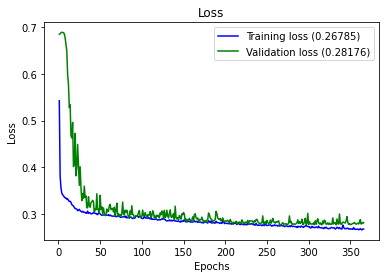

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(X_valid_preproc).reshape(-1),
)
model_auc

0.9247056661481613

<IPython.core.display.Javascript object>

In [28]:
model_auc = roc_auc_score(
    y_true=y_test, y_score=model.predict(X_test_preproc).reshape(-1),
)
model_auc

0.9242110564268156

<IPython.core.display.Javascript object>

In [29]:
# valid 0.9282381974389771 test 0.9262939626480025 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

<IPython.core.display.Javascript object>

In [30]:
SAMPLE_NB = 1000

<IPython.core.display.Javascript object>

In [32]:
sample = X_valid_preproc[:SAMPLE_NB]

<IPython.core.display.Javascript object>

In [33]:
model_pred = model.predict(sample)
model_pred.shape

(1000, 1)

<IPython.core.display.Javascript object>

In [34]:
new_model = Model(inputs=[model.input], outputs=[model.output, model.layers[-3].output])

<IPython.core.display.Javascript object>

In [35]:
new_model_pred, feature_inter = new_model.predict(sample)

<IPython.core.display.Javascript object>

In [36]:
assert np.all(model_pred == new_model_pred)

<IPython.core.display.Javascript object>

In [37]:
feature_inter.shape

(1000, 14, 32)

<IPython.core.display.Javascript object>

In [38]:
for idx in range(sample.shape[1]):
    one_col = np.zeros(sample.shape)
    one_col[:, idx] = sample[:, idx]
    _, feature_inter_one_col = new_model.predict(one_col)
    assert np.all(feature_inter_one_col[:, idx, :] == feature_inter[:, idx, :])
    assert np.sum(feature_inter_one_col - feature_inter) > 1

<IPython.core.display.Javascript object>

In [39]:
idx = 0
one_col = np.zeros(sample.shape)
one_col[:, idx] = sample[:, idx]
_, feature_inter_one_col = new_model.predict(one_col)
assert np.all(feature_inter_one_col[:, idx, :] == feature_inter[:, idx, :])
assert np.sum(feature_inter_one_col - feature_inter) > 1

<IPython.core.display.Javascript object>

In [40]:
feature_inter_one_col[:, 0, :].shape

(1000, 32)

<IPython.core.display.Javascript object>

In [41]:
new_model.layers[-1]

<IPython.core.display.Javascript object>

In [42]:
model.get_weights()[-2].shape

(448, 1)

<IPython.core.display.Javascript object>

In [43]:
new_model = Model(inputs=[model.input], outputs=[model.output, model.layers[-2].output])

<IPython.core.display.Javascript object>

In [44]:
%%time
_, new_train_logistic = new_model.predict(X_train_preproc)
_, new_valid_logistic = new_model.predict(X_valid_preproc)
_, new_test_logistic = new_model.predict(X_test_preproc)

CPU times: user 12.9 s, sys: 9.77 s, total: 22.7 s
Wall time: 6.67 s


<IPython.core.display.Javascript object>

In [45]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

<IPython.core.display.Javascript object>

In [60]:
lreg = LogisticRegression(max_iter=1000, n_jobs=-1)

<IPython.core.display.Javascript object>

In [61]:
new_train_logistic.shape

(26072, 448)

<IPython.core.display.Javascript object>

In [62]:
%%time
lreg.fit(new_train_logistic, y_train.reshape(-1))

CPU times: user 26.6 ms, sys: 88.6 ms, total: 115 ms
Wall time: 2min 3s


LogisticRegression(max_iter=1000, n_jobs=-1)

<IPython.core.display.Javascript object>

In [63]:
roc_auc_score(
    y_true=y_valid, y_score=lreg.predict_proba(new_valid_logistic)[:, 1],
)

0.9236967465427502

<IPython.core.display.Javascript object>

In [64]:
roc_auc_score(
    y_true=y_test, y_score=lreg.predict_proba(new_test_logistic)[:, 1],
)

0.9237837351679689

<IPython.core.display.Javascript object>

In [65]:
lreg_cv = LogisticRegressionCV(Cs=10, max_iter=300, n_jobs=-1, cv=5, random_state=0)

<IPython.core.display.Javascript object>

In [66]:
%%time
lreg_cv.fit(new_train_logistic, y_train.reshape(-1))

CPU times: user 3.38 s, sys: 572 ms, total: 3.95 s
Wall time: 1min 12s


LogisticRegressionCV(cv=5, max_iter=300, n_jobs=-1, random_state=0)

<IPython.core.display.Javascript object>

In [67]:
roc_auc_score(
    y_true=y_valid, y_score=lreg_cv.predict_proba(new_valid_logistic)[:, 1],
)

0.924271040489364

<IPython.core.display.Javascript object>

In [68]:
roc_auc_score(
    y_true=y_test, y_score=lreg_cv.predict_proba(new_test_logistic)[:, 1],
)

0.9241963976451931

<IPython.core.display.Javascript object>